## Import Library

In [7]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [18]:
!kaggle kernels output edenkoresh/breast-cancer-ultrasound-segmentation-segformer -p /path/to/dest

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [8]:
# !pip install transformers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import glob
import shutil
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import get_cosine_schedule_with_warmup
from transformers import SegformerForSemanticSegmentation

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [10]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


## Class Dataset

In [3]:
class BreastCancerDataset(Dataset):
    def __init__(self, paths, transform=None, augment_classes=["malignant","normal"],
                 dup_factor=2, mode="train"):
        """
        paths: list of mask paths
        transform: Albumentations transform (for training)
        augment_classes: classes to duplicate when training
        dup_factor: duplication factor for augment_classes
        mode: 'train' or 'test'
        """
        self.paths=paths
        self.transform=transform
        self.augment_classes=augment_classes or []
        self.dup_factor=dup_factor
        self.mode=mode
        self.labels=[os.path.basename(os.path.dirname(p)) for p in paths]

    def __len__(self):
        if self.mode=="test":
            return len(self.paths)  # no enlargement in test mode
        n=0
        for lbl in self.labels:
            if lbl in self.augment_classes:
                n+=self.dup_factor
            else:
                n+=1
        return n
        
    def __getitem__(self, index):
        # Map back to real index
        if self.mode=="test":
            real_idx=index
        else:
            counter=0
            for real_idx,lbl in enumerate(self.labels):
                reps=self.dup_factor if lbl in self.augment_classes else 1
                if index<counter+reps:
                    break
                counter+=reps
            lbl=self.labels[real_idx]

        path=self.paths[real_idx]
        image=cv2.imread(path.replace("_mask.png",".png"))
        mask=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        mask[mask==255]=1

        if self.mode=="train":
            # Decide original vs augmented
            if self.transform and (lbl in self.augment_classes) and (index!=counter):
                transformed=self.transform(image=image,mask=mask)
            else:
                transformed=test_transform(image=image,mask=mask)
        else:  # test mode always uses test_transform
            transformed=test_transform(image=image,mask=mask)

        image,mask=transformed["image"],transformed["mask"]
        return image.float(),mask.float(),self.labels[real_idx]


In [4]:
size = 512
train_transform = A.Compose([
    A.Resize(size, size),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.Affine(shear=15, translate_percent=0.05, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Perspective(scale=(0.15, 0.15),p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])
    # A.RandomRotate90(),
    # A.GaussianBlur(),
    # A.ElasticTransform(alpha=1.0),

test_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

## UnNormalized

In [5]:
class UnNormalized(object):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unNorm = UnNormalized()

In [6]:
root='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
all_paths = glob.glob(f"{root}/*/*_mask.png")
labels = [p.split("/")[-2] for p in all_paths]

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, labels, test_size=0.30, random_state=159, stratify=labels
)

val_paths, test_paths, _, _ = train_test_split(
    temp_paths, temp_labels, test_size=0.50, random_state=159, stratify=temp_labels
)

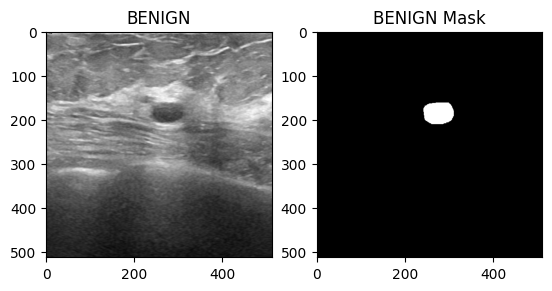

In [7]:
train_dataset = BreastCancerDataset(paths=train_paths, transform=train_transform, mode="train")
val_dataset = BreastCancerDataset(paths=val_paths, transform=test_transform, mode="test")
test_dataset = BreastCancerDataset(paths=test_paths, transform=test_transform, mode="test")

image, mask, label = train_dataset[random.randint(1, len(train_dataset))]
plt.subplot(1, 2, 1)
plt.imshow(unNorm(image).permute(1, 2, 0))
plt.title(label.upper())

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title(f'{label.upper()} Mask')
plt.show()

In [8]:
from collections import Counter

counts=Counter()
for lbl in train_dataset.labels:
    reps=train_dataset.dup_factor if lbl in train_dataset.augment_classes else 1
    counts[lbl]+=reps

print(counts)

Counter({'benign': 306, 'malignant': 294, 'normal': 186})


## AverageMeter

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n = 1):
        self.val += val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Show Loss

In [10]:
def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Val Loss')
    plt.title('Training and Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
    if val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, val_mean_iou, 'b', label='Val Mean IoU')
        plt.title('Training and Val Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
    if val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, val_dice_score, 'b', label='Val Dice Score')
        plt.title('Training and Val Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Calculate Intersection And Union

In [11]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

## Train

In [12]:
upsample = nn.Upsample(scale_factor=4, mode='bilinear')

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [14]:
def train(train_dataset, val_dataset, num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # train_dataset = BreastCancerDataset(transform=train_transform)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers
    )
    
    # val_dataset = BreastCancerDataset(is_train=False, transform=test_transform)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=n_workers
    )

    version = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(version)
    
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-4)
    
    num_batch = len(train_loader)
    
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_batch*epochs, power=0.9)

    if os.path.isdir(checkpoint):
        shutil.rmtree(checkpoint)
    os.makedirs(checkpoint)
    
    if not os.path.isdir(saved_model):
        os.makedirs(saved_model)
    
    writer = SummaryWriter(checkpoint)
    
    train_loss = []
    val_loss = []
    val_mIoU = []
    val_mDice = []
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    train_loss_meter = AverageMeter()
    val_loss_meter = AverageMeter()
    
    no_improvement_counter = 0
    patience = 5
    best_mIoU = -1
    
    for epoch in range(epochs):
        model.train()
        train_loss_meter.reset()
        val_loss_meter.reset()
        intersection_meter.reset()
        union_meter.reset()
        
        progress_bar = tqdm(train_loader, colour='cyan')
        
        for i, (image, mask, __) in enumerate(progress_bar):
            image, mask = image.to(device), mask.to(device)
            
            output = model(image).logits
            output = upsample(output).squeeze()
            loss = criterion(output, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_meter.update(loss.item())
            progress_bar.set_description(f"Train | Epoch {epoch + 1}/{epochs} | Loss {train_loss_meter.avg:.4f} | lr {optimizer.param_groups[0]['lr']}")
            writer.add_scalar("Train/Loss AVG", train_loss_meter.avg, num_batch * epoch + i)
            writer.add_scalar("Train/Loss", loss.item(), num_batch * epoch + i)
            scheduler.step()
        
        model.eval()
        with torch.no_grad():
            progress_bar = tqdm(iterable=val_loader, colour='yellow')
            
            for image, mask, _ in progress_bar:
                image, mask = image.to(device), mask.to(device)
                
                output = model(image).logits
                output = upsample(output).squeeze()
                loss = criterion(output, mask)
                
                val_loss_meter.update(loss.item())
                output[output>=0.5] = 1
                output[output<0.5] = 0
                output = output.long()
                mask = mask.long()
                
                intersection, union, target = intersectionAndUnionGPU(output, mask, 2)           
                intersection_meter.update(intersection)
                union_meter.update(union)
                
                iou = intersection / (union + 1e-10)
                mean_iou = np.mean(iou.cpu().numpy())
                dice = 2 * intersection / (intersection + union + 1e-10)

                dice_value = dice.mean().item()
                
                intersection_meter.update(intersection)
                union_meter.update(union)
                val_loss_meter.update(loss.item())
                
                progress_bar.set_description(f"Val | Loss {loss.item():.4f} | mIoU: {mean_iou:.4f} | dice: {dice_value:.4f}")
            
            
            iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
            dice_class = 2 * intersection_meter.sum / (intersection_meter.sum + union_meter.sum + 1e-10)
            
            mIoU = iou_class.mean().item()
            mDice = dice_class.mean().item()
            print(f"Val | Loss {val_loss_meter.avg:.4f} | mIoU: {mIoU:.4f} | dice: {mDice:.4f}")
            
            writer.add_scalar("Val/Loss", val_loss_meter.avg, epoch)
            writer.add_scalar("Val/mIoU", mIoU, epoch)
            writer.add_scalar("Val/dice", mDice, epoch)
            
            checkpoint_data = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "mIoU": mIoU,
                "mDice": mDice
            }
            
            torch.save(checkpoint_data, os.path.join(saved_model, "last.pt"))
            
            if mIoU > best_mIoU:
                best_mIoU = mIoU
                torch.save(checkpoint_data, os.path.join(saved_model, "best.pt"))
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1
              
            train_loss.append(train_loss_meter.avg)
            val_loss.append(val_loss_meter.avg)
            val_mIoU.append(mIoU)
            val_mDice.append(mDice)
            
            if no_improvement_counter > patience:
                print("Early stopping!")
                break
    
    plot_segmentation_metrics(train_loss, val_loss, None, val_mIoU, None, val_mDice)


In [15]:
import gc

for _ in range(3):
    torch.cuda.empty_cache()
    
    gc.collect()

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/190M [00:00<?, ?B/s]

  0%|          | 0/99 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/50 | Loss 0.3725 | lr 9.821640505939635e-05: 100%|██████████| 99/99 [04:30<00:00,  2.26s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/50 | Loss 0.3725 | lr 9.821640505939635e-05: 100%|██████████| 99/99 [04:30<00:00,  2.74s/it]
Val | Loss 0.2542 | mIoU: 0.5378 | dice: 0.6292: 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]


Val | Loss 0.1828 | mIoU: 0.5634 | dice: 0.6432


Train | Epoch 2/50 | Loss 0.1690 | lr 9.641094812547076e-05: 100%|██████████| 99/99 [04:27<00:00,  2.70s/it]
Val | Loss 0.1439 | mIoU: 0.7977 | dice: 0.8802: 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]


Val | Loss 0.1262 | mIoU: 0.7674 | dice: 0.8550


Train | Epoch 3/50 | Loss 0.1260 | lr 9.460172640897476e-05: 100%|██████████| 99/99 [04:27<00:00,  2.70s/it]
Val | Loss 0.1197 | mIoU: 0.8070 | dice: 0.8864: 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]


Val | Loss 0.1101 | mIoU: 0.7646 | dice: 0.8521


Train | Epoch 4/50 | Loss 0.0985 | lr 9.278865170996503e-05: 100%|██████████| 99/99 [04:25<00:00,  2.69s/it]
Val | Loss 0.1603 | mIoU: 0.7425 | dice: 0.8383: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]


Val | Loss 0.1376 | mIoU: 0.6991 | dice: 0.7958


Train | Epoch 5/50 | Loss 0.0826 | lr 9.097163179756734e-05: 100%|██████████| 99/99 [04:27<00:00,  2.70s/it]
Val | Loss 0.1197 | mIoU: 0.8046 | dice: 0.8848: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


Val | Loss 0.1055 | mIoU: 0.7694 | dice: 0.8560


Train | Epoch 6/50 | Loss 0.0762 | lr 8.915057013195751e-05: 100%|██████████| 99/99 [04:26<00:00,  2.69s/it]
Val | Loss 0.1181 | mIoU: 0.8167 | dice: 0.8931: 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]


Val | Loss 0.1028 | mIoU: 0.7720 | dice: 0.8583


Train | Epoch 7/50 | Loss 0.0704 | lr 8.732536556040212e-05: 100%|██████████| 99/99 [04:28<00:00,  2.71s/it]
Val | Loss 0.1350 | mIoU: 0.7964 | dice: 0.8790: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


Val | Loss 0.1349 | mIoU: 0.7229 | dice: 0.8179


Train | Epoch 8/50 | Loss 0.0627 | lr 8.549591198427764e-05: 100%|██████████| 99/99 [04:28<00:00,  2.71s/it]
Val | Loss 0.1058 | mIoU: 0.8432 | dice: 0.9109: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]


Val | Loss 0.1247 | mIoU: 0.7819 | dice: 0.8663


Train | Epoch 9/50 | Loss 0.0614 | lr 8.366209799353993e-05: 100%|██████████| 99/99 [04:29<00:00,  2.72s/it]
Val | Loss 0.1253 | mIoU: 0.8189 | dice: 0.8948: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val | Loss 0.1105 | mIoU: 0.7804 | dice: 0.8648


Train | Epoch 10/50 | Loss 0.0523 | lr 8.182380646458736e-05: 100%|██████████| 99/99 [04:28<00:00,  2.72s/it]
Val | Loss 0.1360 | mIoU: 0.8258 | dice: 0.8995: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]


Val | Loss 0.1202 | mIoU: 0.7811 | dice: 0.8654


Train | Epoch 11/50 | Loss 0.0498 | lr 7.99809141168445e-05: 100%|██████████| 99/99 [04:28<00:00,  2.71s/it] 
Val | Loss 0.1619 | mIoU: 0.7836 | dice: 0.8698: 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]


Val | Loss 0.1204 | mIoU: 0.7643 | dice: 0.8524


Train | Epoch 12/50 | Loss 0.0470 | lr 7.813329102265838e-05: 100%|██████████| 99/99 [04:27<00:00,  2.70s/it]
Val | Loss 0.1122 | mIoU: 0.8154 | dice: 0.8923: 100%|██████████| 21/21 [00:08<00:00,  2.49it/s]


Val | Loss 0.1060 | mIoU: 0.7984 | dice: 0.8782


Train | Epoch 13/50 | Loss 0.0439 | lr 7.628080006423193e-05: 100%|██████████| 99/99 [04:29<00:00,  2.72s/it]
Val | Loss 0.1343 | mIoU: 0.7995 | dice: 0.8812: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]


Val | Loss 0.1066 | mIoU: 0.7714 | dice: 0.8576


Train | Epoch 14/50 | Loss 0.0432 | lr 7.442329633028074e-05: 100%|██████████| 99/99 [04:28<00:00,  2.72s/it]
Val | Loss 0.1334 | mIoU: 0.8011 | dice: 0.8823: 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]


Val | Loss 0.1118 | mIoU: 0.7800 | dice: 0.8642


Train | Epoch 15/50 | Loss 0.0359 | lr 7.256062644385859e-05: 100%|██████████| 99/99 [04:29<00:00,  2.73s/it]
Val | Loss 0.1118 | mIoU: 0.8622 | dice: 0.9230: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]


Val | Loss 0.1071 | mIoU: 0.8021 | dice: 0.8809


Train | Epoch 16/50 | Loss 0.0366 | lr 7.069262781130324e-05: 100%|██████████| 99/99 [04:28<00:00,  2.72s/it]
Val | Loss 0.1542 | mIoU: 0.8204 | dice: 0.8957: 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]


Val | Loss 0.1282 | mIoU: 0.7776 | dice: 0.8626


Train | Epoch 17/50 | Loss 0.0327 | lr 6.881912778044823e-05: 100%|██████████| 99/99 [04:29<00:00,  2.72s/it]
Val | Loss 0.1523 | mIoU: 0.8092 | dice: 0.8880: 100%|██████████| 21/21 [00:08<00:00,  2.50it/s]


Val | Loss 0.1199 | mIoU: 0.7882 | dice: 0.8707


Train | Epoch 18/50 | Loss 0.0335 | lr 6.693994269404806e-05: 100%|██████████| 99/99 [04:28<00:00,  2.71s/it]
Val | Loss 0.1372 | mIoU: 0.8334 | dice: 0.9044: 100%|██████████| 21/21 [00:08<00:00,  2.53it/s]


Val | Loss 0.1234 | mIoU: 0.7919 | dice: 0.8736


Train | Epoch 19/50 | Loss 0.0365 | lr 6.50548768216821e-05: 100%|██████████| 99/99 [04:30<00:00,  2.73s/it] 
Val | Loss 0.1847 | mIoU: 0.8115 | dice: 0.8897: 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]


Val | Loss 0.1304 | mIoU: 0.7941 | dice: 0.8749


Train | Epoch 20/50 | Loss 0.0341 | lr 6.316372115009945e-05: 100%|██████████| 99/99 [04:29<00:00,  2.73s/it]
Val | Loss 0.1312 | mIoU: 0.8260 | dice: 0.8995: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val | Loss 0.1454 | mIoU: 0.7701 | dice: 0.8570


Train | Epoch 21/50 | Loss 0.0277 | lr 6.12662520078848e-05: 100%|██████████| 99/99 [04:29<00:00,  2.72s/it] 
Val | Loss 0.2098 | mIoU: 0.7886 | dice: 0.8734: 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]


Val | Loss 0.1570 | mIoU: 0.7558 | dice: 0.8455
Early stopping!


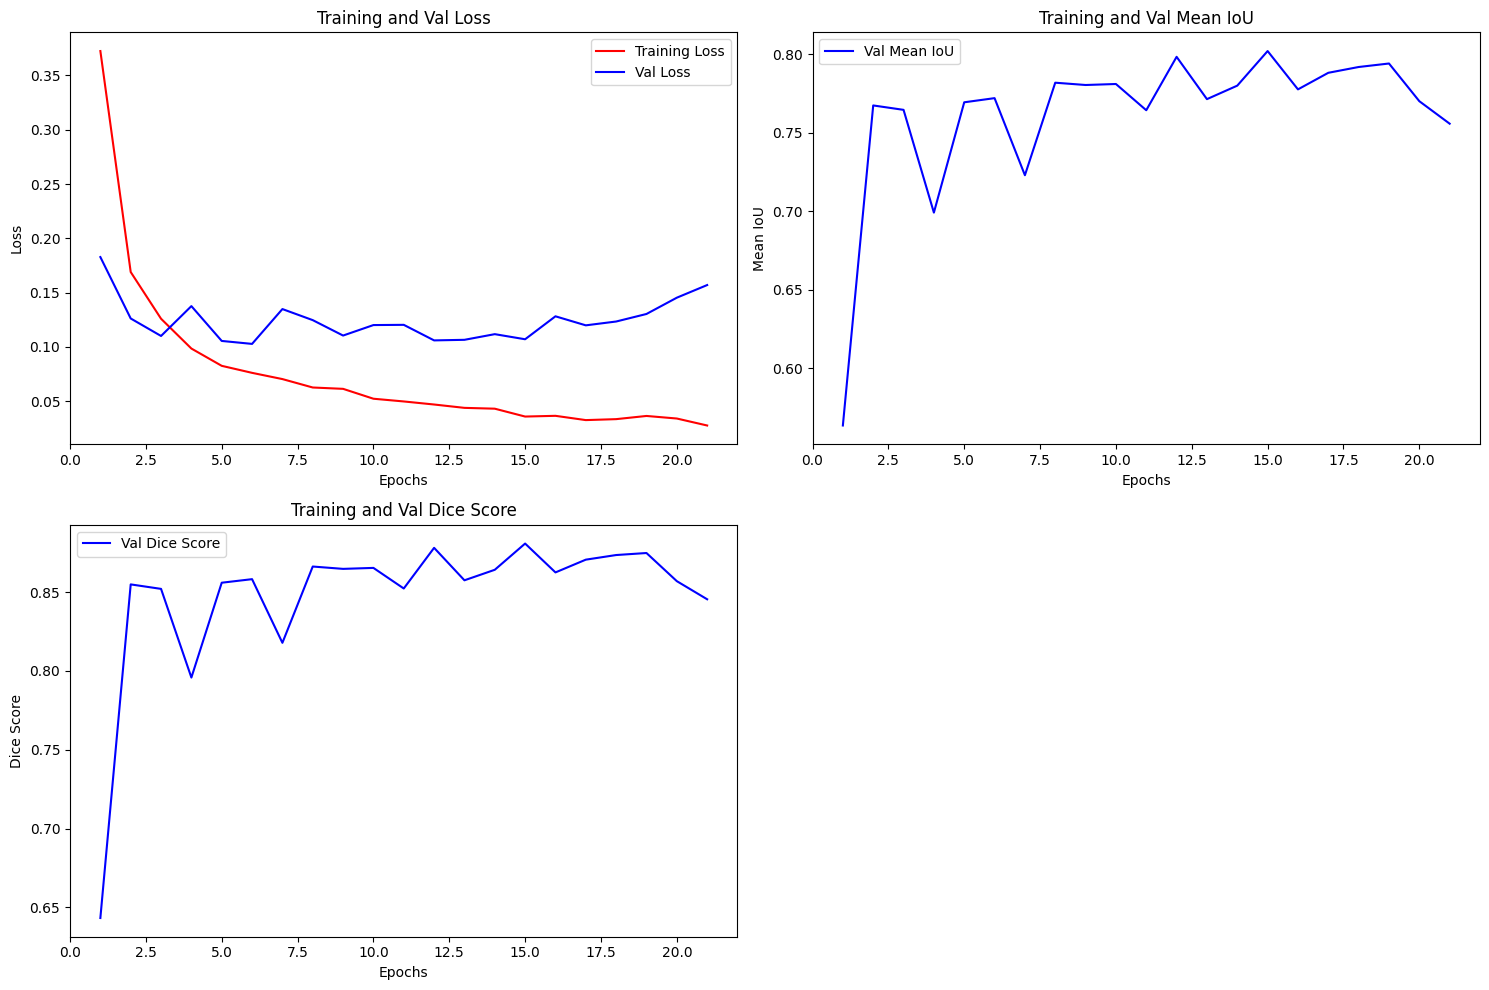

In [24]:
num_class = 2
n_workers = int(os.cpu_count())
# print(n_workers)
batch_size = 8
lr = 1e-4
epochs = 50
checkpoint = "/kaggle/working/tensorboard"
saved_model = "/kaggle/working/saved_model"

train(train_dataset, val_dataset, num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model)

## Inference

In [25]:
def pred_show_best_worst_per_label(model_pth, device, test_dataset, num_class, top_k=4):
    # Load model checkpoint
    checkpoint = torch.load(model_pth, map_location=device)
    
    # Initialize and load model state
    model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(model_name)
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Dict to store per-category results
    results_by_label = {label: [] for label in test_dataset.labels}

    with torch.no_grad():
        for idx in range(len(test_dataset)):
            ori_img, orig_mask, label = test_dataset[idx]
            img = ori_img.float().to(device).unsqueeze(0)

            # Get logits and prob map
            logits = model(img).logits
            prob_mask = torch.sigmoid(upsample(logits)).squeeze().cpu().numpy()  # shape (H,W)
            pred_mask = (prob_mask >= 0.5).astype(np.uint8)
            
            # Predict mask
            pred_mask = upsample(model(img).logits).squeeze()
            pred_mask[pred_mask>=0.5] = 1
            pred_mask[pred_mask<0.5] = 0
            pred_mask = pred_mask.long()

            # Compute IoU
            intersection, union, _ = intersectionAndUnionGPU(pred_mask, orig_mask.long().to(device), K=num_class)
            iou = (intersection / (union + 1e-10)).mean().item()

            # Infer label from file path
            # path = test_dataset.path[idx]
            # label = os.path.basename(os.path.dirname(path))  # e.g., benign/malignant/normal

            # Reconstruct RGB image
            img_np = unNorm(ori_img).permute(1,2,0).numpy()  # shape (H,W,3), float in [0,1]
            img_uint8 = (img_np * 255).astype(np.uint8)

            # Generate heatmap
            heatmap = cv2.applyColorMap((prob_mask*255).astype(np.uint8), cv2.COLORMAP_JET)
            heatmap_overlay = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)

            results_by_label[label].append((
                idx, iou, img_uint8, orig_mask.numpy(), pred_mask.cpu().numpy(), heatmap_overlay
            ))

            # results_by_label[label].append((
            #     idx,
            #     iou,
            #     unNorm(ori_img).permute(1,2,0),
            #     orig_mask.numpy(),
            #     pred_mask.cpu().numpy()
            # ))

    # Plot best and worst per category
    for label, results in results_by_label.items():
        if not results:
            continue
        results.sort(key=lambda x: x[1])  # sort by IoU

        worst_samples = results[:top_k]
        best_samples = results[-top_k:]

        display_samples = worst_samples + best_samples

        fig = plt.figure(figsize=(24, 12))
        fig.suptitle(f"{label.upper()} - {top_k} Worst and {top_k} Best Predictions", fontsize=16)

        for i, (idx, iou, img, gt, pred, heatmap_overlay) in enumerate(display_samples, 1):
            fig.add_subplot(4, len(display_samples), i)
            plt.imshow(img)
            plt.title(f"Image {idx}\nIoU={iou:.4f}")
            plt.axis("off")

            fig.add_subplot(4, len(display_samples), i + len(display_samples))
            plt.imshow(gt, cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            fig.add_subplot(4, len(display_samples), i + 2*len(display_samples))
            plt.imshow(pred, cmap="gray")
            plt.title("Prediction")
            plt.axis("off")

            fig.add_subplot(4, len(display_samples), i + 3*len(display_samples))
            plt.imshow(heatmap_overlay)
            plt.title("Heatmap Overlay")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


/tmp/ipykernel_30/3727912990.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth, map_location=device)


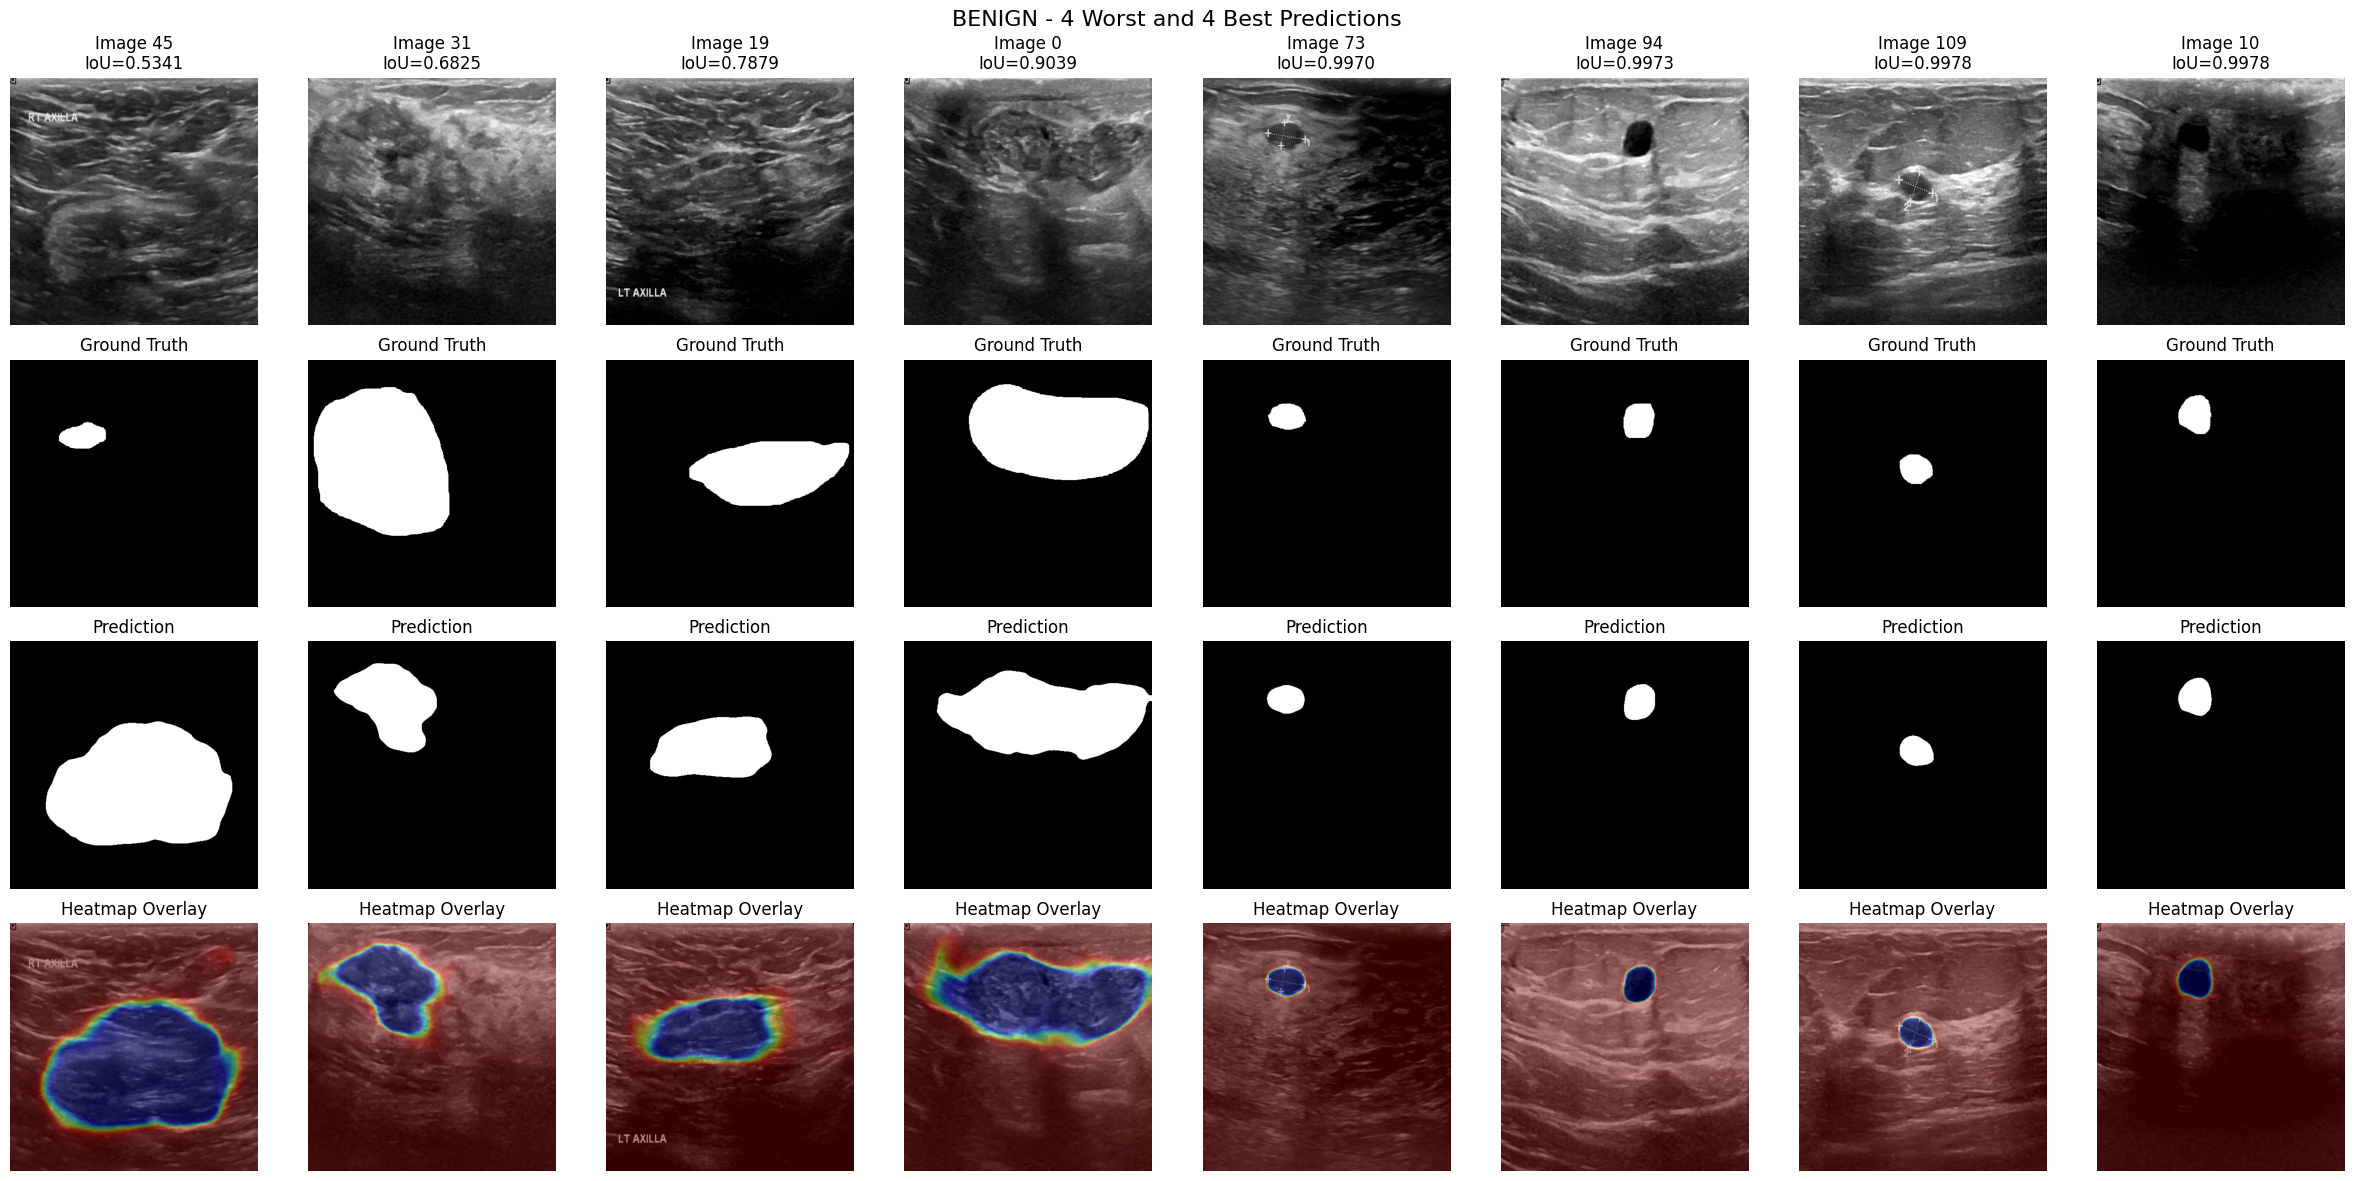

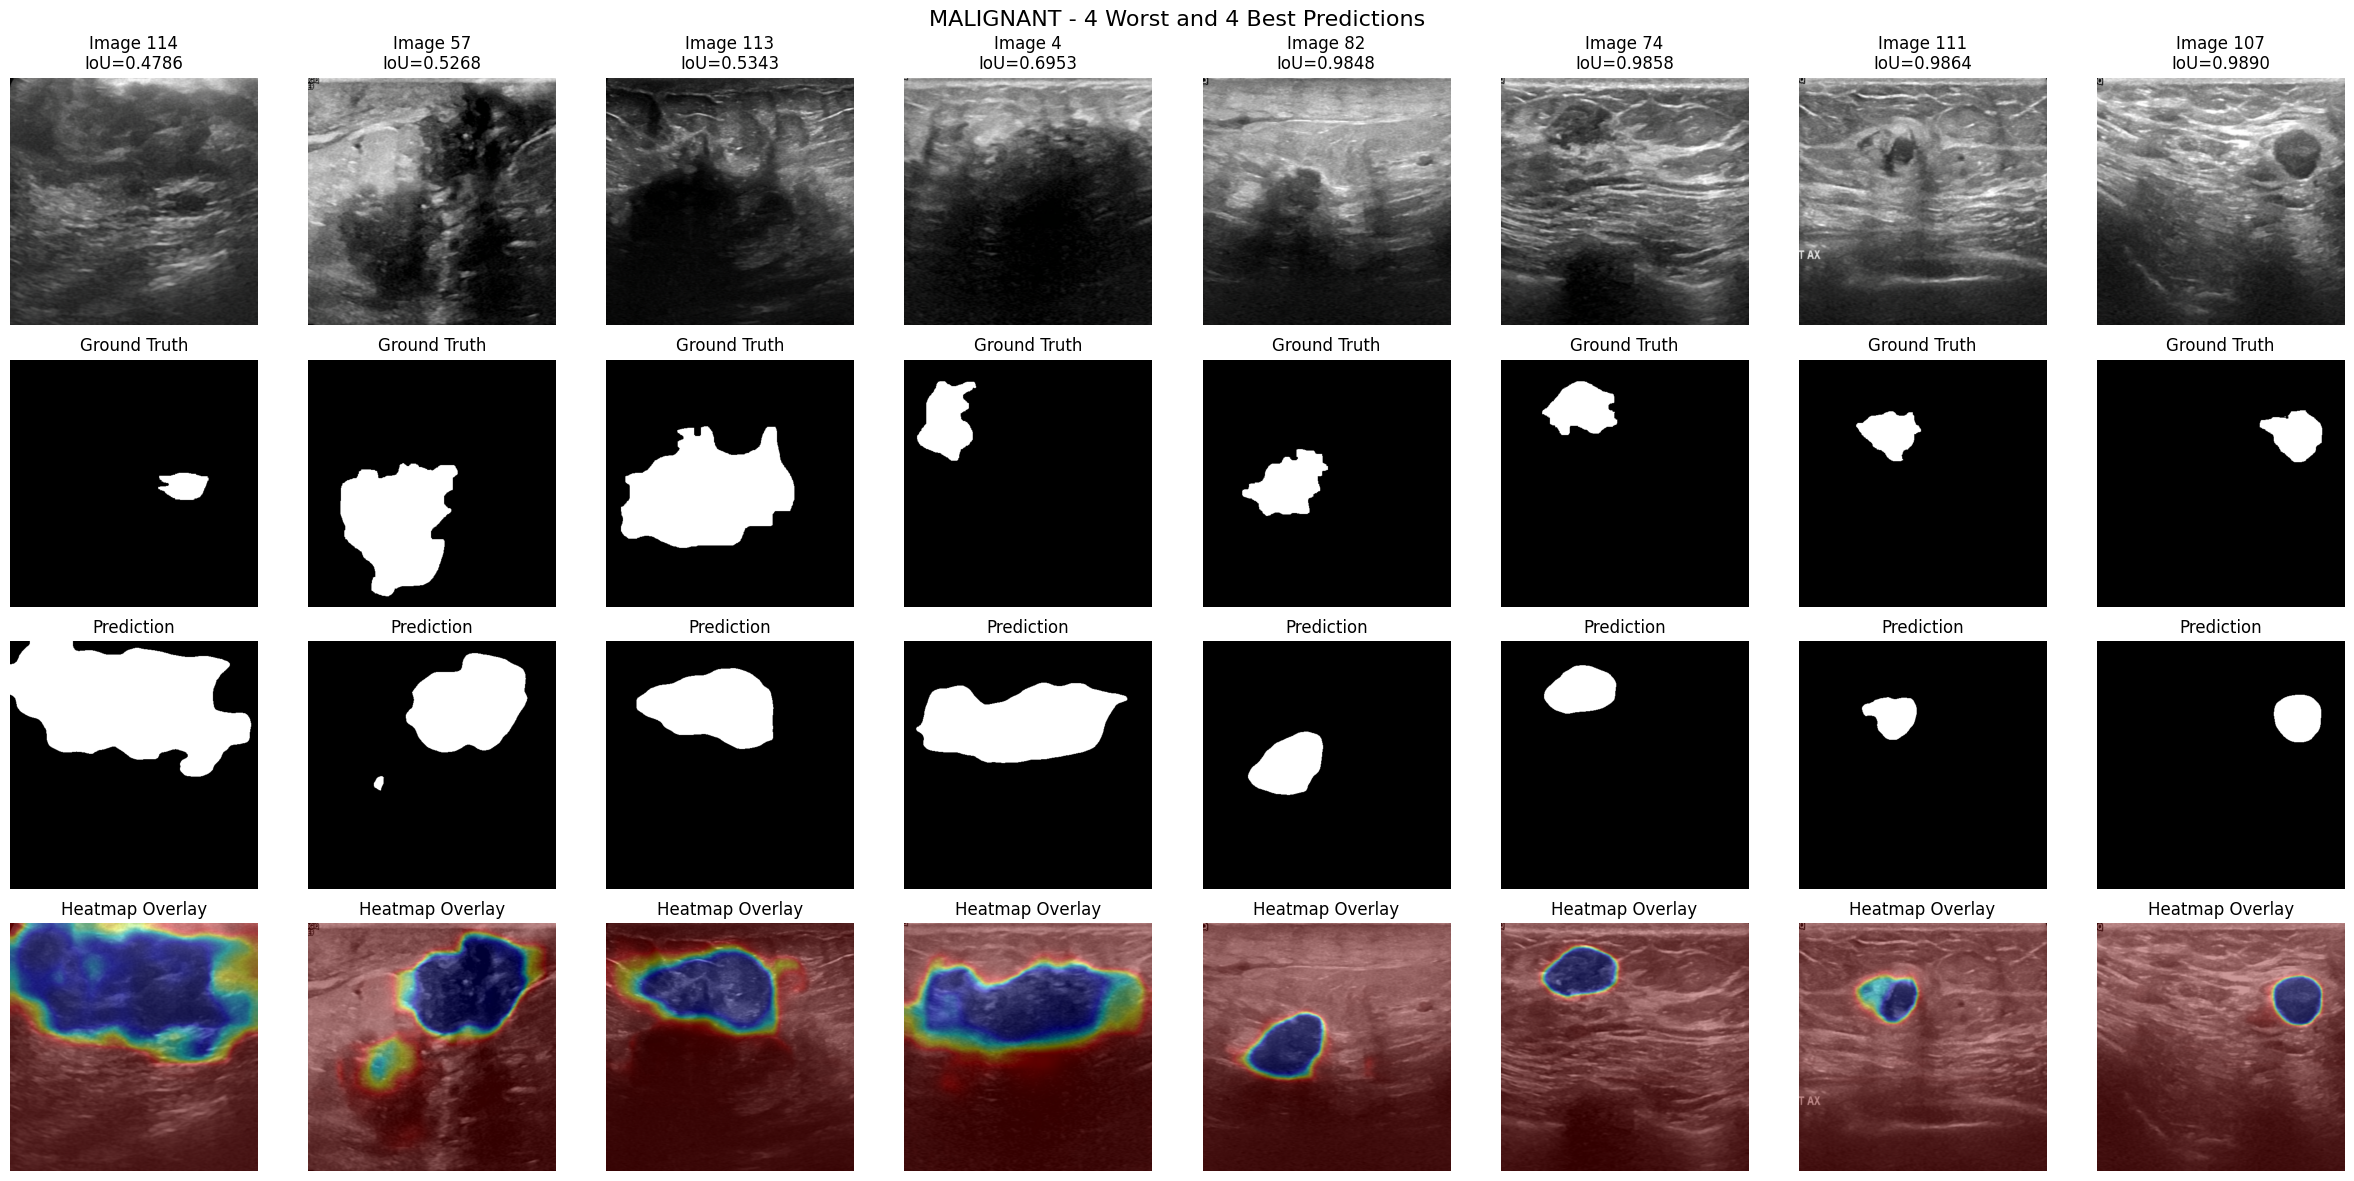

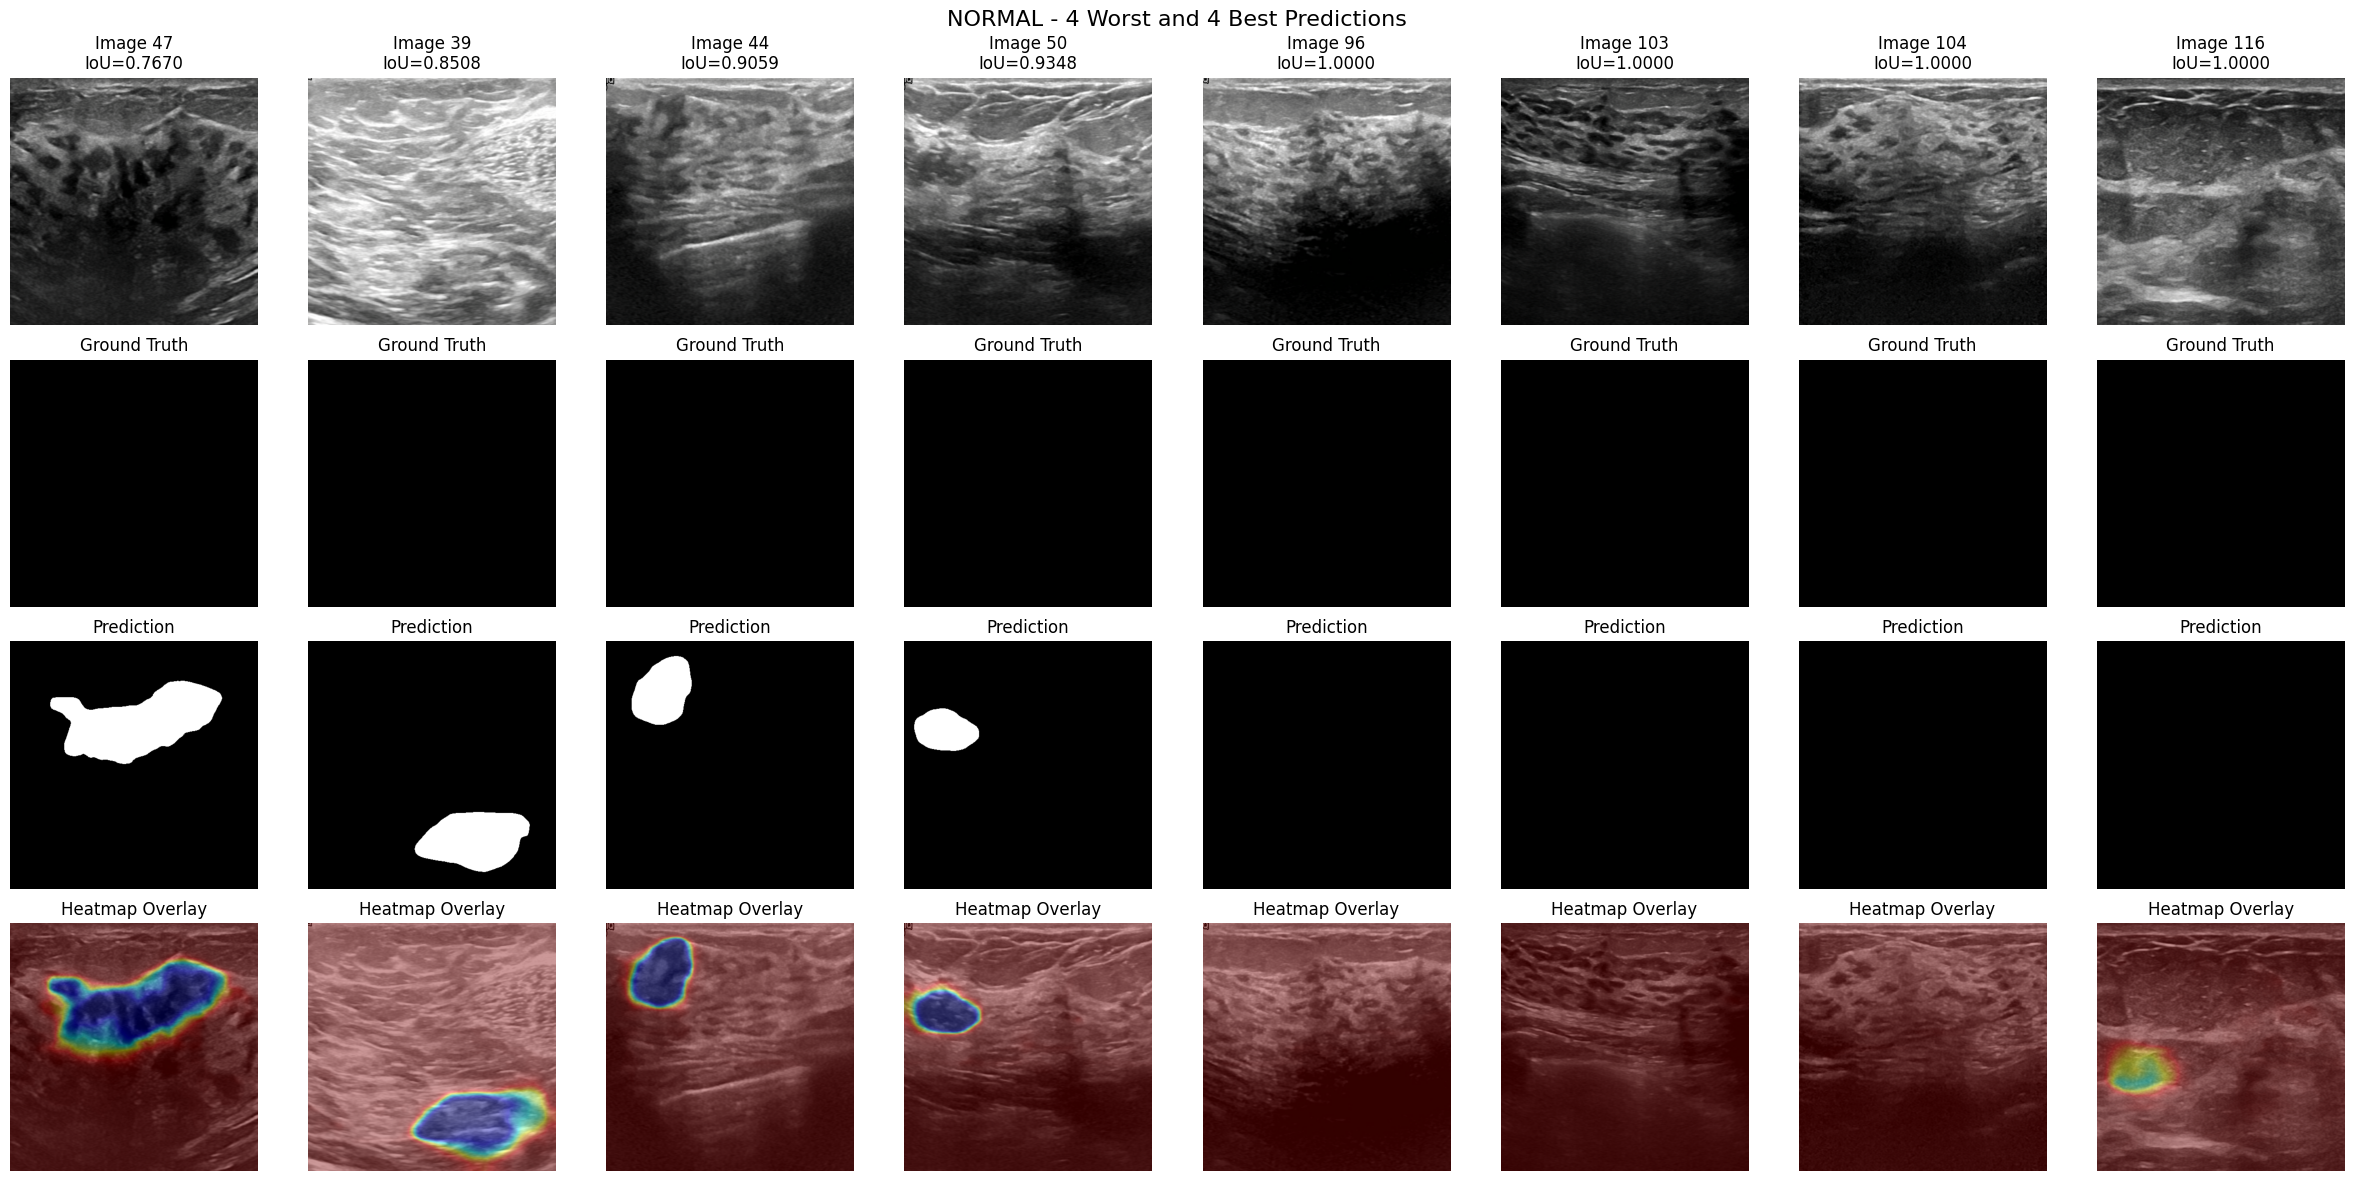

In [41]:
model_pth = "/kaggle/working/saved_model/best.pt"
pred_show_best_worst_per_label(model_pth, device, test_dataset, num_class, top_k=4)

In [ ]:
len(test_dataset)

# Classification

In [28]:
class BreastCancerMaskDataset(Dataset):
    def __init__(self, root='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT',
                 split="train", transform=None):
        self.categories = ["benign", "malignant", "normal"]
        self.transform = transform
        self.path = glob.glob(f"{root}/*/*_mask.png")
        
        random.seed(159)
        random.shuffle(self.path)
        
        total_len = len(self.path)
        train_end = int(total_len * 0.70)
        val_end = int(total_len * 0.85)
        
        if split == "train":
            self.path = self.path[:train_end]
        elif split == "val":
            self.path = self.path[train_end:val_end]
        elif split == "test":
            self.path = self.path[val_end:]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

    def __len__(self):
        return len(self.path)

    def __getitem__(self, index):
        mask_path = self.path[index]
        label = os.path.basename(os.path.dirname(mask_path))
        label_idx = self.categories.index(label)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask == 255] = 1  # ensure binary

        if self.transform:
            mask = self.transform(image=mask)["image"]

        return mask.float(), torch.tensor(label_idx, dtype=torch.long)


In [29]:
mask_transform = A.Compose([
    A.Resize(224,224),  # match ResNet input
    A.Normalize(mean=(0.5,), std=(0.5,)),  # single channel
    ToTensorV2()
])


In [30]:
class MaskClassifier(nn.Module):
    def __init__(self, num_classes=3):  # benign, malignant, normal
        super(MaskClassifier, self).__init__()
        # Use pretrained ResNet18
        self.resnet = models.resnet18(pretrained=True)
        # Change input conv to accept 1 channel (binary mask)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Replace final layer for 3-class classification
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [31]:
# Datasets
train_dataset = BreastCancerMaskDataset(split="train", transform=mask_transform)
val_dataset = BreastCancerMaskDataset(split="val", transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MaskClassifier(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training
epochs = 50
best_val_acc = 0.0
patient = 5
patient_brake = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct, total = 0, 0
    
    for masks, labels in train_loader:
        masks, labels = masks.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc = correct / total
    
    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for masks, labels in val_loader:
            masks, labels = masks.to(device), labels.to(device)
            outputs = model(masks)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.4f}")

    # Step the scheduler
    scheduler.step(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/mask_classifier_best.pt")
        print("Saved Best Model!")
        patient_brake = 0
    else:
        patient_brake +=1

    if patient_brake > patient:
        print("Early brake initiated")
        break


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.7MB/s]


Epoch [1/50] Train Loss: 0.5810, Acc: 0.7674 Val Loss: 1.5973, Acc: 0.1966
Saved Best Model!
Epoch [2/50] Train Loss: 0.2568, Acc: 0.9322 Val Loss: 4.5966, Acc: 0.2393
Saved Best Model!
Epoch [3/50] Train Loss: 0.2088, Acc: 0.9286 Val Loss: 2.7502, Acc: 0.2393
Epoch [4/50] Train Loss: 0.1347, Acc: 0.9579 Val Loss: 3.6207, Acc: 0.2393
Epoch [5/50] Train Loss: 0.1993, Acc: 0.9652 Val Loss: 1.0730, Acc: 0.5726
Saved Best Model!
Epoch [6/50] Train Loss: 0.0950, Acc: 0.9707 Val Loss: 0.6339, Acc: 0.7778
Saved Best Model!
Epoch [7/50] Train Loss: 0.0806, Acc: 0.9853 Val Loss: 0.1412, Acc: 0.9573
Saved Best Model!
Epoch [8/50] Train Loss: 0.1008, Acc: 0.9634 Val Loss: 0.6834, Acc: 0.6068
Epoch [9/50] Train Loss: 0.0467, Acc: 0.9908 Val Loss: 0.6957, Acc: 0.5385
Epoch [10/50] Train Loss: 0.0244, Acc: 0.9945 Val Loss: 0.1030, Acc: 0.9744
Saved Best Model!
Epoch [11/50] Train Loss: 0.0197, Acc: 0.9963 Val Loss: 0.1054, Acc: 0.9744
Epoch [12/50] Train Loss: 0.0335, Acc: 0.9982 Val Loss: 0.1071, A

In [16]:
model_pth = "/kaggle/working/saved_model/best.pt"
# Load SegFormer checkpoint
checkpoint = torch.load(model_pth, map_location=device)

model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
segformer = SegformerForSemanticSegmentation.from_pretrained(model_name)

in_channels = segformer.decode_head.classifier.in_channels
segformer.decode_head.classifier = nn.Conv2d(in_channels, 1, kernel_size=1, stride=1)  # 1 class

segformer.load_state_dict(checkpoint["model_state_dict"])
segformer.to(device)
segformer.eval()

# Test on SegFormer predicted masks
# test_dataset = MaskOnlyDataset(root,split="test",transform=None)
model.load_state_dict(torch.load("/kaggle/working/mask_classifier_best.pt"))
model.eval()

all_preds,all_labels = [],[]

with torch.no_grad():
    for idx in range(len(test_dataset)):
        ori_img, orig_mask, label = test_dataset[idx]
        img = ori_img.float().to(device).unsqueeze(0)

        # Get logits and prob map
        logits = segformer(img).logits
        prob_mask = torch.sigmoid(upsample(logits)).squeeze().cpu().numpy()  # shape (H,W)
        pred_mask = (prob_mask >= 0.5).astype(np.uint8)
        
        # Predict mask
        pred_mask = upsample(segformer(img).logits).squeeze()
        pred_mask[pred_mask>=0.5] = 1
        pred_mask[pred_mask<0.5] = 0
        pred_mask = pred_mask.long()

        # Reconstruct RGB image
        img_np = unNorm(ori_img).permute(1,2,0).numpy()  # shape (H,W,3), float in [0,1]
        img_uint8 = (img_np * 255).astype(np.uint8)

        # print(np.size(img))

        # mask_path = test_dataset.path[idx]
        # label = os.path.basename(os.path.dirname(mask_path))
        label_idx = test_dataset.labels.index(label)

        # print(torch.Tensor.size(pred_mask.unsqueeze(0).unsqueeze(0)))
        # Classify predicted mask
        outputs = model(pred_mask.unsqueeze(0).unsqueeze(0).float().to(device))
        pred_class = outputs.argmax(1).item()

        if idx%100:
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(img_uint8)
            plt.title(label_idx)
            
            plt.subplot(1, 2, 2)
            plt.imshow(pred_mask.cpu(), cmap='gray')
            plt.title(pred_class)
            plt.show()

        all_preds.append(pred_class)
        all_labels.append(label_idx)

/tmp/ipykernel_30/2568460733.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth, map_location=device)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/saved_model/best.pt'

{'malignant', 'benign', 'normal'}


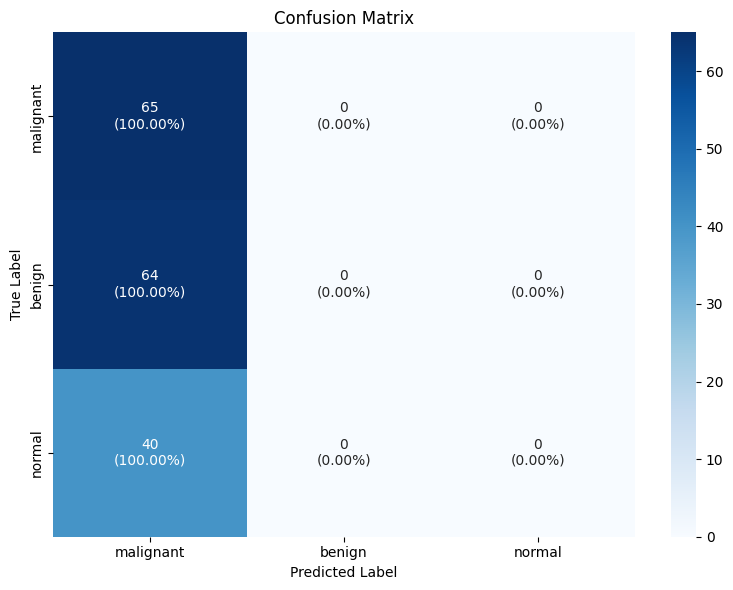

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# Convert to numpy arrays if not already
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Get class names from dataset
class_names = set(test_dataset.labels)
print(set(class_names))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize to percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent = np.nan_to_num(cm_percent)  # Handle division by zero if it occurs

# Create annotations: counts and percentages
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        annotations[i, j] = f"{count}\n({percent:.2f}%)"

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [34]:
# all_preds = np.array(all_preds)
# all_labels = np.array(all_labels)

# print("Classification on SegFormer Predicted Masks")
# print(classification_report(all_labels, all_preds, target_names=test_dataset.categories))
# print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

Classification on SegFormer Predicted Masks


AttributeError: 'BreastCancerDataset' object has no attribute 'categories'

In [ ]:
# all_preds = np.array(all_preds)
# all_labels = np.array(all_labels)

# acc = accuracy_score(all_labels, all_preds)
# prec = precision_score(all_labels, all_preds, average="macro")
# rec = recall_score(all_labels, all_preds, average="macro")
# f1 = f1_score(all_labels, all_preds, average="macro")
# print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
# print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))
